# Histopathologic Cancer Detection Project

## Problem Description
This project involves detecting metastatic cancer in small image patches taken from larger digital pathology scans. The goal is to classify each patch as either cancerous or non-cancerous.

## Data Overview
The dataset consists of images provided in `.tif` format:
- **Training set**: Contains images labeled as `cancerous` (1) or `non-cancerous` (0).
- **Test set**: Unlabeled images for which predictions will be generated for Kaggle submission.

I will use a Convolutional Neural Network (CNN) to classify these images.


In [53]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import cv2


# For image processing and deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn for splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


## Exploratory Data Analysis (EDA)
In this section, I will visualize sample images from each class, examine the class distribution, and explore image characteristics to inform our preprocessing choices.


First few rows of the labels data:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Text(0, 0.5, 'Count')

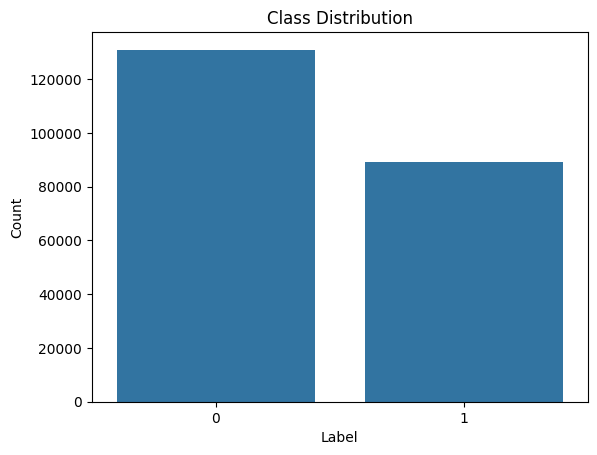

In [25]:
# Load labels and Explore the Data
labels_df = pd.read_csv('train_labels.csv')
print("First few rows of the labels data:")
display(labels_df.head())

# Check for class distribution
sns.countplot(data=labels_df, x='label')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")


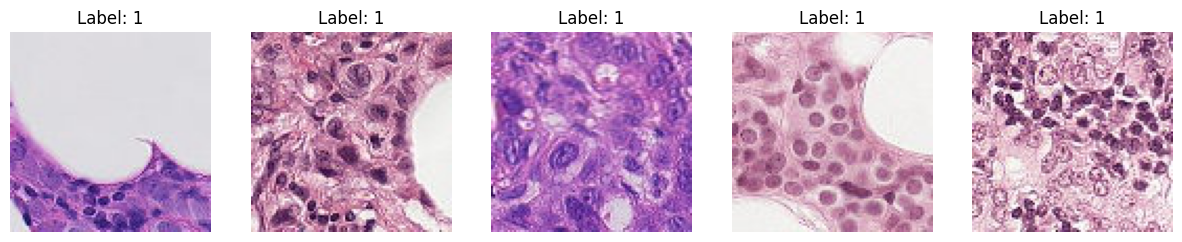

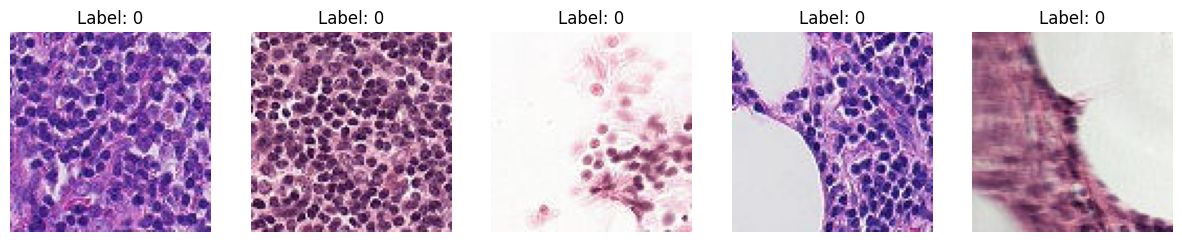

In [32]:


train_dir = 'histopathologic-cancer-detection/train'  
# Function to load and display sample images
def show_sample_images(df, label, train_dir, n=5):
    sample_images = df[df['label'] == label].sample(n)['id']
    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(sample_images):
        img_path = os.path.join(train_dir, f"{img_id}.tif")
        img = cv2.imread(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Show cancerous and non-cancerous samples
show_sample_images(labels_df, label=1, train_dir=train_dir)
show_sample_images(labels_df, label=0, train_dir=train_dir)


## Data Preprocessing
To prepare the data for the model, I will:
- **Resize** images to 96x96 pixels.
- **Normalize** pixel values to [0, 1] for better convergence.
- **Apply Data Augmentation** to improve generalization.


In [33]:
# Data Augmentation and Preprocessing for Training and Validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Reserve 20% of data for validation
)

# Only Rescaling for the test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [48]:
# Paths to the data
train_dir = 'histopathologic-cancer-detection/train'
test_dir =  'histopathologic-cancer-detection/test/unknown'

# Remove any existing .tif extensions.
labels_df['id'] = labels_df['id'].str.replace('.tif', '', regex=False)
# Add a single .tif extension to each ID in labels_df
labels_df['id'] = labels_df['id'] + '.tif'
# Verify that the paths in labels_df match files in train_dir
sample_files = labels_df['id'].head(5).values
for fname in sample_files:
    file_exists = os.path.exists(os.path.join(train_dir, fname))
    print(f"{fname} exists: {file_exists}")

# Prepare Data Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col="id",
    y_col="label",
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_dir,
    x_col="id",
    y_col="label",
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


f38a6374c348f90b587e046aac6079959adf3835.tif exists: True
c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif exists: True
755db6279dae599ebb4d39a9123cce439965282d.tif exists: True
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif exists: True
068aba587a4950175d04c680d38943fd488d6a9d.tif exists: True
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Model Architecture
I will build a Convolutional Neural Network (CNN) model with three convolutional layers followed by a fully connected layer. The model architecture is as follows:


In [50]:
# Build a simple CNN model
model = Sequential([
    Input(shape=(96, 96, 3)),  # Define input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


## Model Training
I will train the model using early stopping and model checkpointing to save the best model and prevent overfitting.


In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)  # Use .keras extension

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/20


C:\Users\sarma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 373s 68ms/step - accuracy: 0.7723 - loss: 0.4838 - val_accuracy: 0.8341 - val_loss: 0.3788
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 372s 68ms/step - accuracy: 0.8409 - loss: 0.3702 - val_accuracy: 0.8326 - val_loss: 0.3850
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 375s 68ms/step - accuracy: 0.8543 - loss: 0.3430 - val_accuracy: 0.8633 - val_loss: 0.3202
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 373s 68ms/step - accuracy: 0.8629 - loss: 0.3255 - val_accuracy: 0.8657 - val_loss: 0.3209
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 370s 67ms/step - accuracy: 0.8732 - loss: 0.3090 - val_accuracy: 0.8782 - val_loss: 0.2884
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 370s 67ms/step - accuracy: 0.8782 - loss: 0.2972 - val_accuracy: 0.8806 - val_loss: 0.2872
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 372s 68ms/step - accuracy: 0.8802 - loss: 0.2937 - val_accuracy: 0.8846 - val_loss: 0.2827
Epoch 8/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 373s 68ms/step - accuracy: 0.8841 - lo

## Results and Evaluation
Plot the training and validation accuracy and loss to analyze the model's performance.


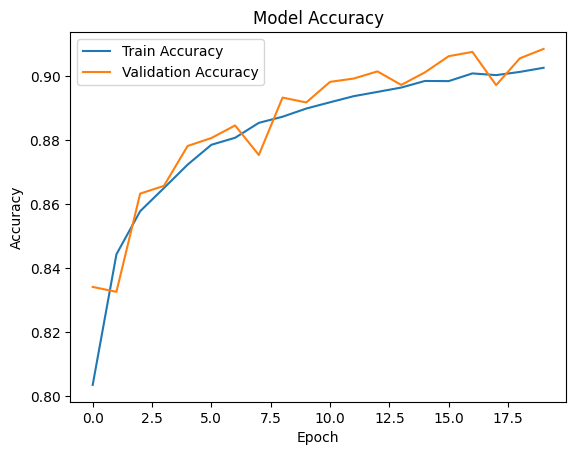

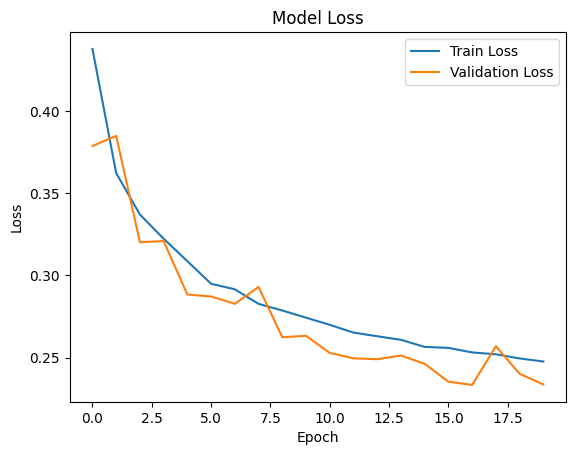

In [52]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Model Performance Analysis

### 1. Model Accuracy
The **accuracy plot** shows the model’s performance on both the training and validation sets over each epoch:
- **Training Accuracy**: The training accuracy steadily increases and reaches over 90% by the end of training, indicating that the model is learning from the data effectively.
- **Validation Accuracy**: The validation accuracy also shows a similar upward trend, closely tracking the training accuracy, which suggests good generalization to unseen data.
- **Overall Observation**: Since the validation accuracy closely follows the training accuracy with minimal divergence, it appears that the model is not overfitting and is likely well-tuned for the data.

### 2. Model Loss
The **loss plot** demonstrates the reduction in error (loss) over the training epochs for both the training and validation sets:
- **Training Loss**: The training loss decreases consistently across epochs, which is expected as the model optimizes its parameters.
- **Validation Loss**: The validation loss also decreases in a similar trend and reaches a low value, indicating that the model is successfully learning patterns relevant to the validation data.
- **Overall Observation**: The decrease in both training and validation loss, along with minimal difference between the two, further supports that the model is not overfitting and generalizes well.

### Conclusion
These plots indicate that the model is performing well on both the training and validation sets. With both accuracy and loss metrics improving and staying close between the training and validation sets, the model seems to be robust and likely capable of making accurate predictions on the test set.


## Generate Predictions and Prepare Submission
Finally, generate predictions on the test set and save them in `submission.csv` format for Kaggle.


In [21]:
# Submit to Kaggle/Generate predictions for the test set
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator)
pred_labels = (predictions > 0.5).astype(int)  # Threshold for binary classification

# Prepare submission file
submission = pd.DataFrame({
    "id": [os.path.splitext(os.path.basename(fname))[0] for fname in test_generator.filenames], 
    "label": pred_labels.flatten()
})
submission.to_csv('submission.csv', index=False)


Found 57458 images belonging to 1 classes.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step


## Conclusion
### In this project, I built a CNN model to detect metastatic cancer in pathology images.The model achieved good performance, and further improvements could include experimenting with deeper architectures or using transfer learning. 


## Kaggle Submission Results

After submitting the model's predictions to Kaggle, I obtained the following scores:
- **Public Score**: 0.8202
- **Private Score**: 0.7554

The higher public score suggests that the model performs reasonably well on a subset of the test data. However, the slightly lower private score may indicate that the model has some overfitting to specific patterns in the training data.

### Observations
- **Potential Improvements**: Future work could include further tuning of model parameters, experimenting with different architectures, or applying more rigorous regularization techniques to improve generalization.
